In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, matthews_corrcoef

from xgboost import XGBRegressor

from statsmodels.api import datasets

In [2]:
# df = pd.read_csv("climate/DailyDelhiClimateTrain.csv")
# df_date = df.set_index("date")
# target = 'meantemp'

# df = datasets.nile.load_pandas().data
# df_date = df.set_index("year")
# target = "volume"

# df = pd.read_csv("/data/appli_PITSI/users/targe/dev/valvo/lacq_10_2014_j96a100.txt", sep='\t', nrows=5000, header=None)
df = pd.read_csv("/data/appli_PITSI/users/targe/dev/valvo/lacq_500_2014_j96a100.txt", sep='\t', nrows=1000, header=None)
# df = pd.read_csv("/data/appli_PITSI/users/targe/dev/valvo/LACQ16_TURB_data_brutes_2016_10_25_au_2016_12_22.txt", sep='\t', nrows=5000, header=None)
df = df.drop([0,3,4], axis=1)
df.columns = ['date', "amplitude"]
df_date = df.set_index("date")
target = "amplitude"

n, p = df_date.shape
df_date

,amplitude
date,
0.000426,5.280355
0.000870,5.279525
0.001315,5.279833
0.001759,5.279738
0.002204,5.280046
...,...
0.442656,5.280046
0.443101,5.280556
0.443545,5.280046


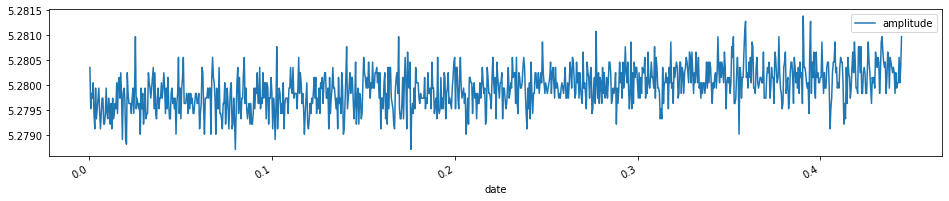

In [3]:
df_date.plot(subplots=True, figsize=(16,3*p));

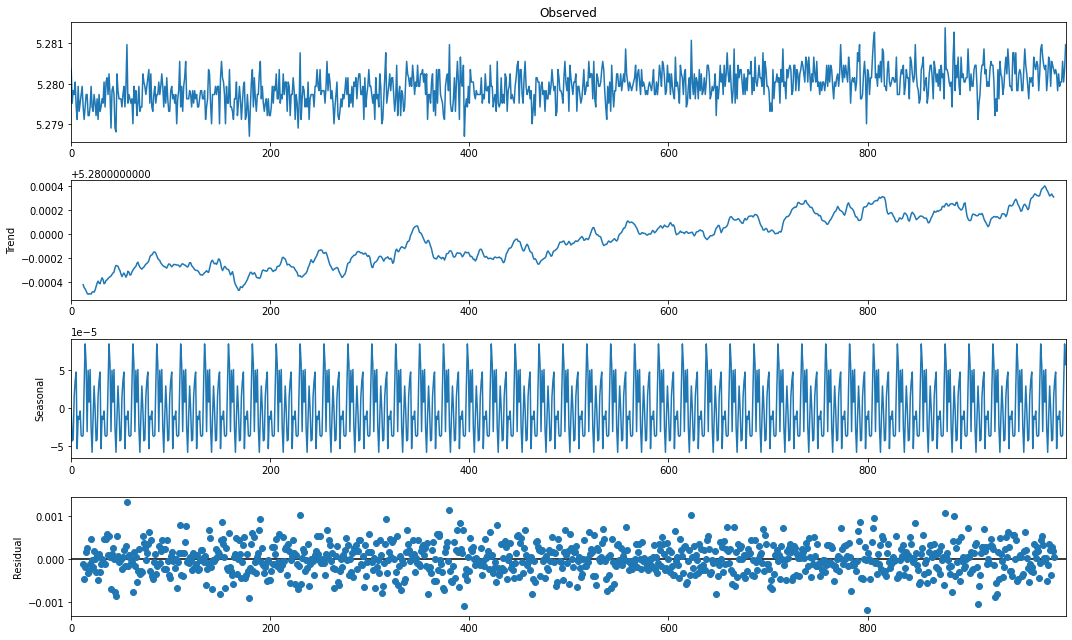

In [4]:
plt.rcParams["figure.figsize"] = (15,9)
sd = seasonal_decompose(df[target].to_list(), period=24, model='additive')
sd.plot();

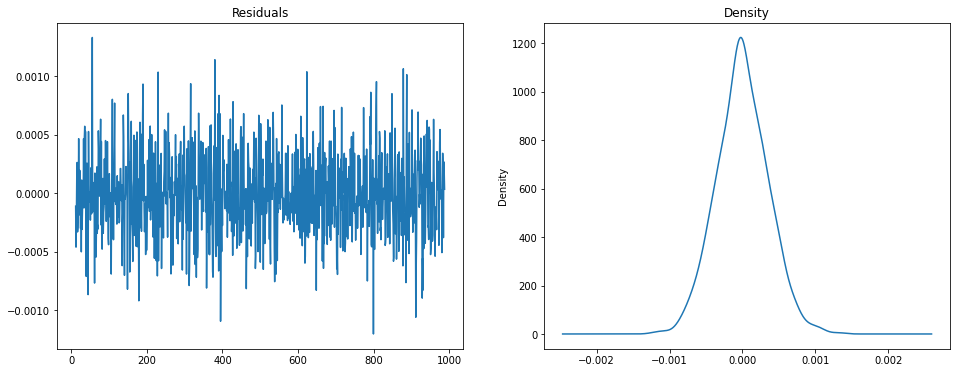

In [5]:
residuals = pd.DataFrame(sd.resid).dropna()
fig, ax = plt.subplots(1,2, figsize=(16,6))
residuals.plot(title="Residuals", legend=False, ax=ax[0])
residuals.plot(kind='kde', title='Density', legend=False, ax=ax[1]);

# ARIMA
https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html?highlight=arima#statsmodels.tsa.arima.model.ARIMA

Find `(p,d,q)` coefficients

## Split data (train, test)

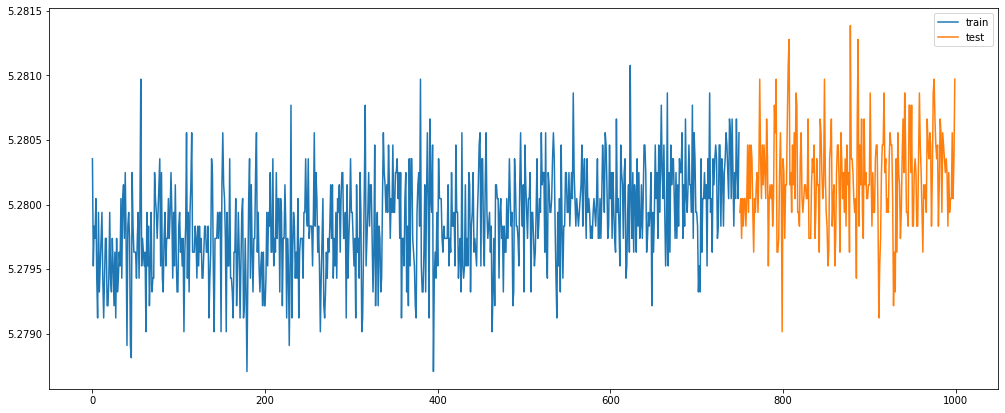

In [6]:
y_train, y_test = train_test_split(df[target], test_size=0.25, shuffle=False)
pd.DataFrame([y_train, y_test]).T.plot(figsize=(17,7))
plt.legend(['train', 'test']);

`p` coef in **AR** term

* Keep the most significant lags (above the significance line)

/data/appli_PITSI/users/targe/miniconda3/envs/dev2/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


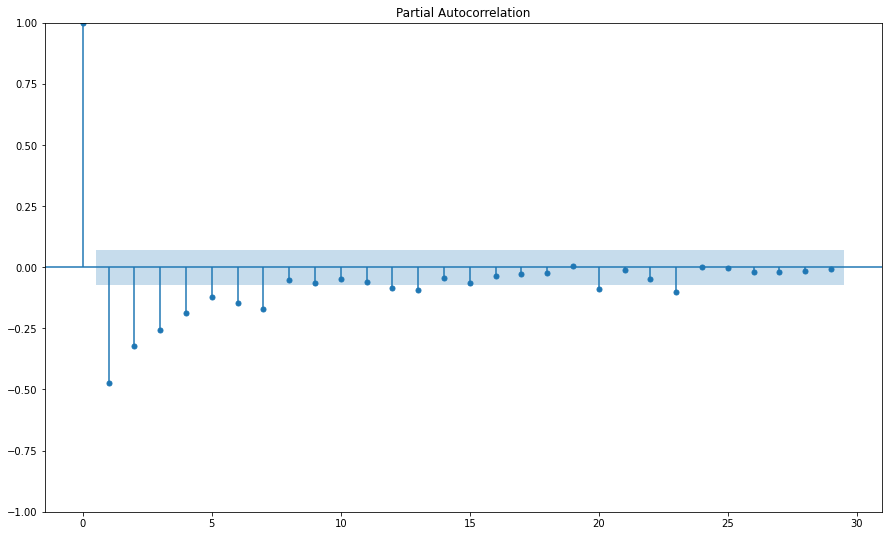

In [7]:
plot_pacf(y_train.diff().dropna());

`d` coef in **I** term

* Differenciate the series until stationarity
* Augmented Dickey Fuller test tests non-stationarity of the series  
$H_0$: non stationary serie  
$H_1$: stationary serie

p-value: 1.4313518024800666e-06


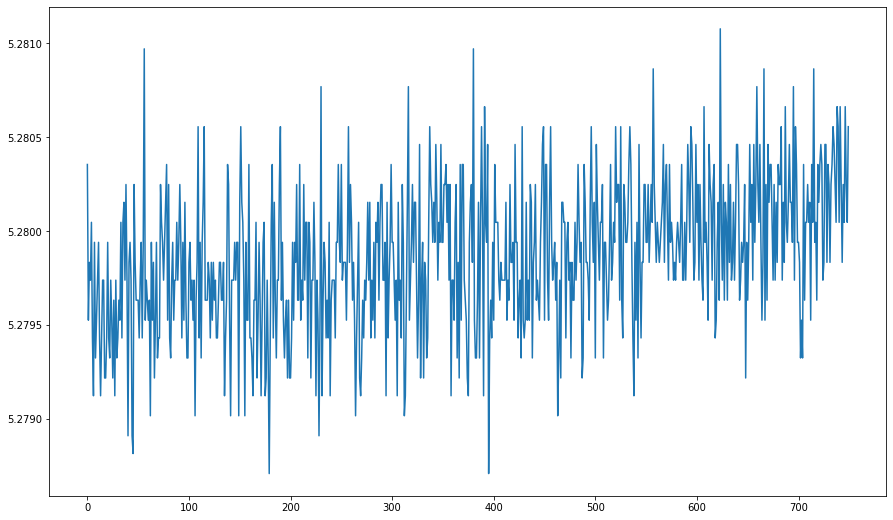

In [8]:
serie = y_train#.diff().dropna()
print(f"p-value: {adfuller(serie)[1]}")
serie.plot();

`q` coef in **MA** term

* Keep the most significant lags (above the significance line)

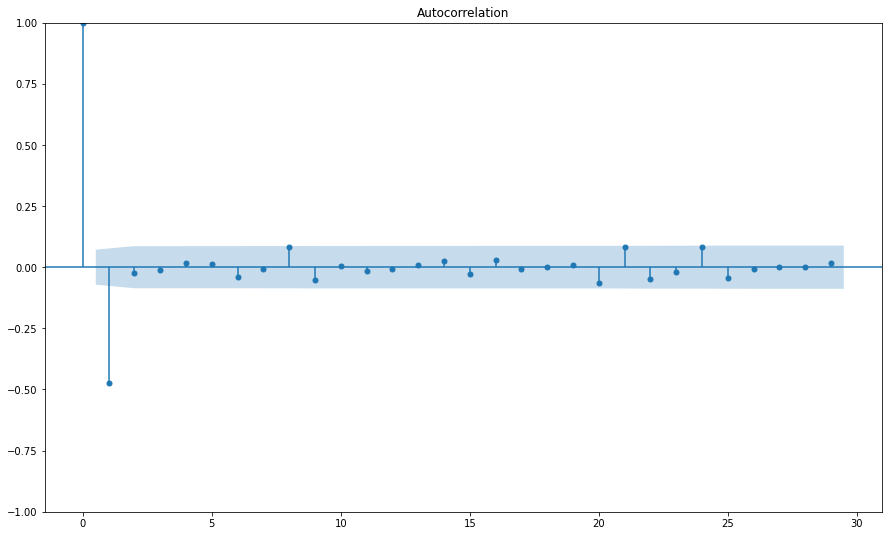

In [9]:
plot_acf(y_train.diff().dropna());

### Find ARIMA coefficients  automatically

In [10]:
import pmdarima as pm

model = pm.auto_arima(y_train, 
                      test='adf',           # use adftest to find optimal 'd'
                      start_p=1, start_q=1, # minimum p and q
                      max_p=3, max_q=3,     # maximum p and q
                      m=1,                  # frequency of series
                      d=None,               # let model determine 'd'
                      seasonal=False,       # seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5297.371, Time=0.96 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4626.258, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.70 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-5393.230, Time=0.56 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.78 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-7588.921, Time=1.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.98 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-7965.805, Time=1.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.78 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-7292.807, Time=0.72 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-9415.945, Time=1.71 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-9668.096, Time=0.37 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-9653.989, Tim

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  750
Model:               SARIMAX(3, 0, 1)   Log Likelihood                4851.747
Date:                Fri, 18 Feb 2022   AIC                          -9691.495
Time:                        15:24:31   BIC                          -9663.774
Sample:                             0   HQIC                         -9680.814
                                - 750                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.2225      0.036     90.606      0.000       3.153       3.292
ar.L1          0.1442      0.058      2.476      0.013       0.030       0.258
ar.L2          0.1206      0.046      2.597      0.009       0.030       0.212
ar.L3          0.1248      0.042      2.976      0.003       0.043       0.207
ma.L1          0.0216      0.071      0.305      0.760      -0.117       0.161
sigma2      1.409e-07   7.25e-09     19.422      0.000    1.27e-07    1.55e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.67   Prob(JB):                         0.75
Heteroskedasticity (H):               0.87   Skew:                             0.06
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.89e+17. Standard errors may be unstable.
"""

In [11]:
model = ARIMA(y_train,order=(5,0,5))#, seasonal_order=(1,1,3,12))
# model = SARIMAX(df[target],order=(1,1,1),seasonal_order=(1,0,1,12))

model_arima = model.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              amplitude   No. Observations:                  750
Model:                 ARIMA(5, 0, 5)   Log Likelihood                4871.605
Date:                Fri, 18 Feb 2022   AIC                          -9719.211
Time:                        15:24:32   BIC                          -9663.770
Sample:                             0   HQIC                         -9697.848
                                - 750                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2799   4.96e-05   1.06e+05      0.000       5.280       5.280
ar.L1          0.1038      0.020      5.200      0.000       0.065       0.143
ar.L2         -0.2419      0.018    -13.266      0.000      -0.278      -0.206
ar.L3          0.2247      0.019     11.981      0.000       0.188       0.261
ar.L4          0.3141      0.021     15.301      0.000       0.274       0.354
ar.L5          0.4620      0.024     19.515      0.000       0.416       0.508
ma.L1          0.0104      0.027      0.387      0.699      -0.042       0.063
ma.L2          0.3089      0.032      9.740      0.000       0.247       0.371
ma.L3         -0.1280      0.034     -3.780      0.000      -0.194      -0.062
ma.L4         -0.2402      0.033     -7.170      0.000      -0.306      -0.175
ma.L5         -0.4323      0.036    -12.004      0.000      -0.503      -0.362
sigma2      1.334e-07   6.85e-09     19.462      0.000     1.2e-07    1.47e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.94
Prob(Q):                              0.80   Prob(JB):                         0.63
Heteroskedasticity (H):               0.85   Skew:                             0.06
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+17. Standard errors may be unstable.
"""

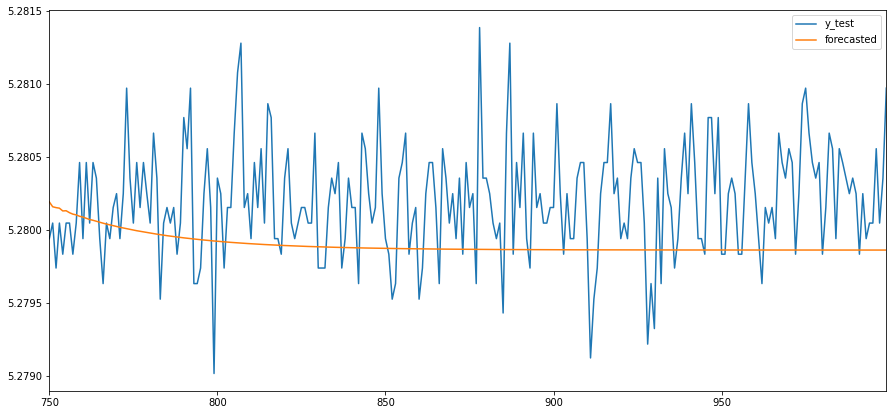

In [12]:
n0 = n*3//4
predictions = model_arima.predict(start=n0, end=n-1, dynamic=False).rename('ARIMA Predictions')

y_test.plot(legend=True, figsize=(15,7))
predictions.plot(legend=True)
plt.legend(["y_test", "forecasted"])
plt.autoscale(axis='x',tight=True);

In [13]:
print(f"mape: {mean_absolute_percentage_error(df[target].iloc[n0:], predictions)}")

print(f"correlation: {np.corrcoef(df[target].iloc[n0:], predictions)[0,1]}")
error = mean_absolute_error(df[target].iloc[n0:], predictions)
print(f"mse: {error}")
df[target].iloc[n0:].mean()

mape: 7.370250237893146e-05
correlation: -0.09540927909313257
mse: 0.0003891798166144582


5.280196593319969

amplitude      mean   mean_se  mean_ci_lower  mean_ci_upper
750        5.280192  0.000365       5.279476       5.280907
751        5.280158  0.000368       5.279438       5.280879
752        5.280152  0.000369       5.279430       5.280875
753        5.280149  0.000370       5.279424       5.280873
754        5.280130  0.000371       5.279402       5.280857
755        5.280131  0.000372       5.279401       5.280860
756        5.280118  0.000373       5.279386       5.280849
757        5.280108  0.000374       5.279374       5.280841
758        5.280102  0.000375       5.279367       5.280838
759        5.280093  0.000376       5.279356       5.280830
760        5.280087  0.000377       5.279349       5.280826
761        5.280079  0.000378       5.279339       5.280819
762        5.280071  0.000378       5.279330       5.280812
763        5.280065  0.000379       5.279323       5.280808
764        5.280059  0.000379       5.279315       5.280802
765        5.280052  0.000380       5.27

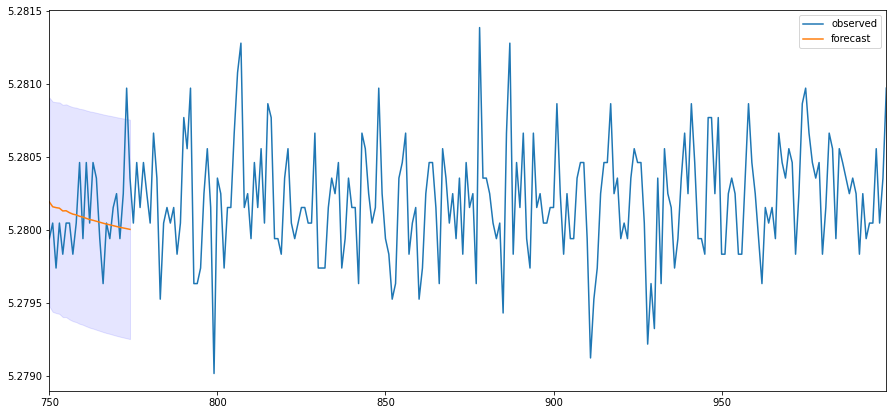

In [14]:
res = model_arima.get_forecast(25).summary_frame(alpha=0.05)
print(res)

y_test.plot(legend=True, figsize=(15,7))
plt.plot(res["mean"]);
plt.autoscale(axis='x',tight=True)
plt.fill_between(res["mean"].index, res["mean_ci_lower"], res["mean_ci_upper"], color='b', alpha=.1)
plt.legend(['observed', 'forecast']);

# ML approach

### Preprocessing

#### Lag differencing

Can be use to remove seasonality if `lag` period is **T**

`lag` can be set to :
* 12 for monthly data
* ...

In [15]:
lag = 1
# df[target] = df[target].diff(lag)
df[target]

0      5.280355
1      5.279525
2      5.279833
3      5.279738
4      5.280046
         ...   
995    5.280046
996    5.280556
997    5.280046
998    5.280355
999    5.280971
Name: amplitude, Length: 1000, dtype: float64

#### Transform data

On a time series dataset, this can have the effect of removing a change in variance over time.

In [16]:
# pt = PowerTransformer()
# df[target] = pt.fit_transform(df[target].to_frame())

#### Scale data

In [17]:
# scaler = [StandardScaler(), MinMaxScaler()][1]
# df[target] = scaler.fit_transform(df[target].to_frame())

### Prepare data

In [19]:
def series_to_supervised(time_series, n_steps_in, n_steps_out, forecast_inputs=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        time_series: Sequence of observations as a list or NumPy array
        n_steps_in: Number of lag observations as input (X)
        n_steps_out: Number of observations as output (y)
        forecast_inputs: whether to forecast inputs (True) or forecast output from inputs (False)
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    def getXcols(cols):
        return list(np.array([list(map(lambda x: x + f'(t-{i})', cols)) for i in range (n_steps_in,0,-1)]).flatten())
    def getYcols(cols):
        return list(np.array([list(map(lambda x: x + '(t' + f'+{i})'*(i!=0)+')'*(i==0), cols)) for i in range (0,n_steps_out)]).flatten())
    
    cols = time_series.columns
    if forecast_inputs:
        new_cols_x = getXcols(cols)
        new_cols_y = getYcols(cols)
    else:
        new_cols_x = getXcols(cols[:-1])
        new_cols_y = getYcols(cols[-1:])
        
    n_inputs = len(new_cols_x)
    n_outputs = len(new_cols_y)
    n_features = n_outputs // n_steps_out

    X, y = [], []
    for i in range(len(time_series)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(time_series):
            break
        # gather input and output parts of the pattern
        if forecast_inputs:
            seq_x, seq_y = time_series.iloc[i:end_ix, :], time_series.iloc[end_ix:out_end_ix, :]
        else:
            seq_x, seq_y = time_series.iloc[i:end_ix, :-1], time_series.iloc[end_ix-1:out_end_ix-1, -1]
        
        X.append(seq_x.to_numpy().flatten())
        y.append(seq_y.to_numpy().flatten())
    
    return [pd.concat([pd.DataFrame(X, columns=new_cols_x), pd.DataFrame(y, columns=new_cols_y)], axis=1),
            n_inputs,
            n_outputs,
           n_features]

df.dropna(inplace=True)
n_steps_in = 5
n_steps_out = 1
per_train = 0.7
time_series = df[[target]]
time_series_train = time_series[:int(n*per_train)]
time_series_test = time_series[int(n*per_train):]

# data, n_inputs, n_outputs, n_features = series_to_supervised(time_series, n_steps_in, n_steps_out, True)
# train, test = train_test_split(data, test_size=0.33, shuffle=False) # test_size dépend de n_previous à cause du dropna
# train, test = data[:int(n*per_train)], data[int(n*per_train):]

train, n_inputs, n_outputs, n_features = series_to_supervised(time_series_train, n_steps_in, n_steps_out, True)
test, _, _, _ = series_to_supervised(time_series_test, n_steps_in, n_steps_out, True)

scaler = [StandardScaler(), MinMaxScaler()][1]
train_scaled = pd.DataFrame(scaler.fit_transform(train))
test_scaled = pd.DataFrame(scaler.transform(test))

x_train, y_train = train_scaled.iloc[:,:-n_outputs], train_scaled.iloc[:,-n_outputs:]
x_test, y_test = test_scaled.iloc[:,:-n_outputs], test_scaled.iloc[:,-n_outputs:]
train

,amplitude(t-5),amplitude(t-4),amplitude(t-3),amplitude(t-2),amplitude(t-1),amplitude(t)
0,5.280355,5.279525,5.279833,5.279738,5.280046,5.279430
1,5.279525,5.279833,5.279738,5.280046,5.279430,5.279122
2,5.279833,5.279738,5.280046,5.279430,5.279122,5.279940
3,5.279738,5.280046,5.279430,5.279122,5.279940,5.279323
4,5.280046,5.279430,5.279122,5.279940,5.279323,5.279525
...,...,...,...,...,...,...
690,5.280153,5.280461,5.280153,5.280153,5.279940,5.280770
691,5.280461,5.280153,5.280153,5.279940,5.280770,5.279738
692,5.280153,5.280153,5.279940,5.280770,5.279738,5.280556
693,5.280153,5.279940,5.280770,5.279738,5.280556,5.280355


#### XGBoost

In [20]:
model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=500)
model_xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=32,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

#### Random Forest

In [21]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=500)
model_rf.fit(x_train, y_train)

/data/appli_PITSI/users/targe/miniconda3/envs/dev2/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(n_estimators=500)

#### LSTM

In [80]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

x_train_reshaped = x_train.to_numpy().reshape((x_train.shape[0], x_train.shape[1]//n_features, n_features))

model_lstm = Sequential()
model_lstm.add(LSTM(units =64, activation='relu', return_sequences=True, input_shape = (n_steps_in, n_features)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units =64, activation='relu', return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units =64, activation='relu', return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=n_outputs)) # Prediction of the next value

model_lstm.compile(optimizer='adam', loss='mae')
model_lstm.summary()

history = model_lstm.fit(x_train_reshaped, y_train, epochs = 30, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 5, 64)             16896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 5, 64)             33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

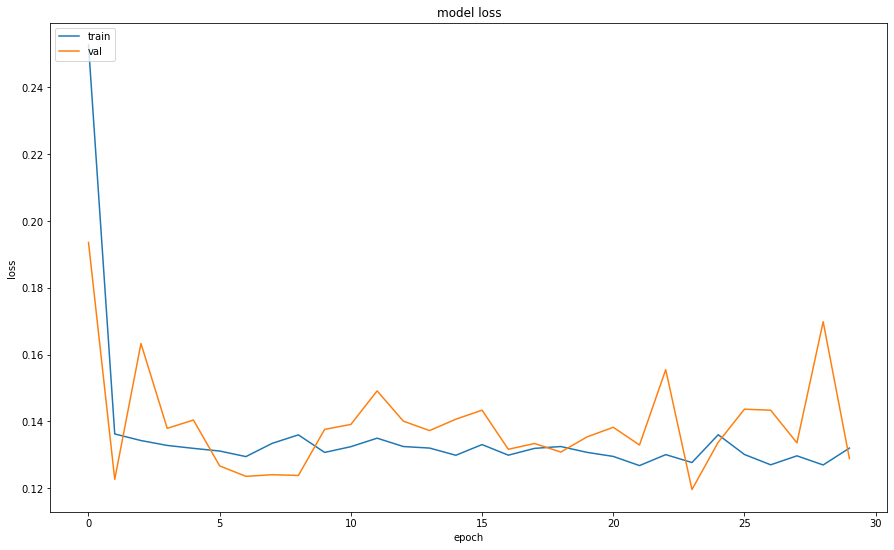

In [81]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch');
plt.legend(['train', 'val'], loc='upper left');

#### CNN

In [82]:
# multivariate output multi-step 1d cnn example
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils import plot_model

x_train_reshaped = x_train.to_numpy().reshape((x_train.shape[0], x_train.shape[1]//n_features, n_features))

model_nn = Sequential()
model_nn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps_in, n_features)))
model_nn.add(MaxPooling1D(pool_size=2))
model_nn.add(Flatten())
model_nn.add(Dense(30, activation='relu'))
model_nn.add(Dense(30, activation='relu'))
model_nn.add(Dense(n_outputs))
model_nn.compile(optimizer='adam', loss='mae')
# fit model
model_nn.summary()
history = model_nn.fit(x_train_reshaped, y_train, epochs=50, verbose=1, validation_split=0.1)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 3, 64)             256       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 30)                1950      
_________________________________________________________________
dense_23 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 31        
Total params: 3,167
Trainable params: 3,167
Non-trainable params: 0
___________________________________________________

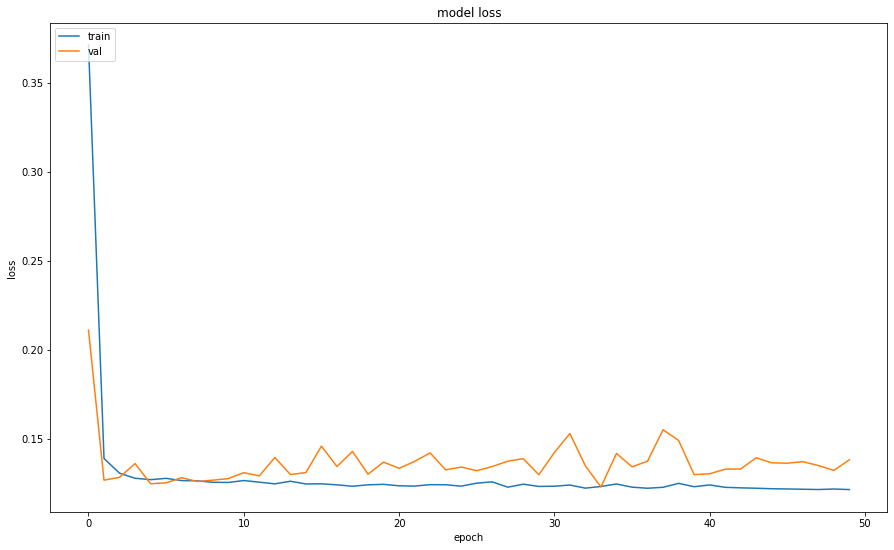

In [83]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch');
plt.legend(['train', 'val'], loc='upper left');

In [ ]:
from skopt import gp_minimize

def f_nn(param):
    filters = param[0]
    
    model_nn = Sequential()
    model_nn.add(Conv1D(filters=filters, kernel_size=3, activation='relu', input_shape=(n_steps_in, n_features)))
    model_nn.add(MaxPooling1D(pool_size=2))
    model_nn.add(Flatten())
    # model_nn.add(Dense(10, activation='relu'))
    model_nn.add(Dense(n_outputs))
    model_nn.compile(optimizer='adam', loss='mape')
    # fit model
    history = model_nn.fit(x_train_reshaped, y_train, epochs=80, verbose=0)
    
    x_test_reshaped = x_test.to_numpy().reshape((x_test.shape[0], x_test.shape[1]//n_features, n_features))
    y_pred = model_nn.predict(x_test_reshaped)

    mape = mean_absolute_percentage_error(y_test, y_pred)
    return mape
    
# f = lambda x: x[0]**2-x[0]-1
res = gp_minimize(f_nn,                  # the function to minimize
                  [(32, 128)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=5,         # the number of evaluations of f
                  n_random_starts=2,  # the number of random initialization points
                  initial_point_generator="lhs",
                  n_jobs=-1,
                  random_state=0)   # the random seed

In [ ]:
print(f"x_min = {res['x']}: \nf_min = {res['fun']}")
# res['x_iters']

from skopt.plots import plot_convergence
plot_convergence(res);

#### Comparaison modèles

mape: 0.24256228466595467
mse: 0.1523169623331064
y_test_mean: [0.62859492]
correlation: -0.07497341729958416


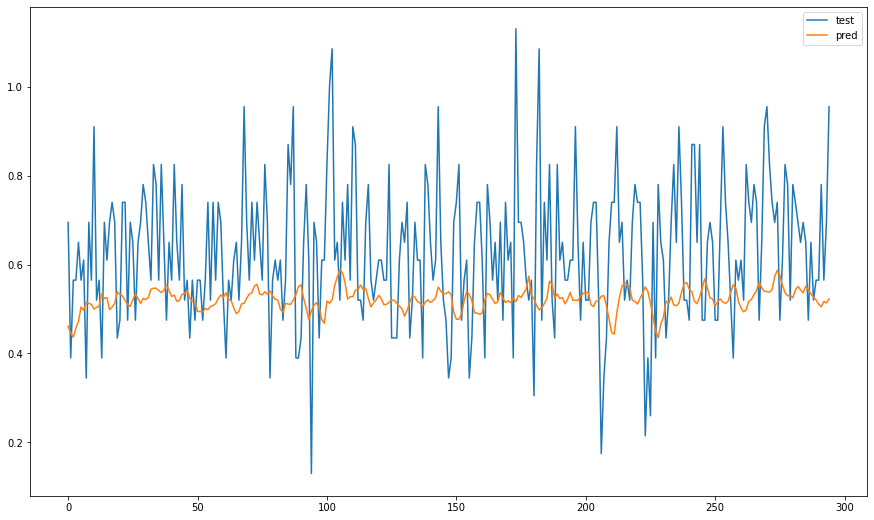

In [85]:
model_ml = [model_xgb, model_rf, model_nn, model_lstm][3]
# y_pred = model_ml.predict(x_test)

x_test_reshaped = x_test.to_numpy().reshape((x_test.shape[0], x_test.shape[1]//n_features, n_features))
y_pred = model_ml.predict(x_test_reshaped)

error = mean_absolute_error(y_test, y_pred)
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
print(f"mse: {error}")
print(f"y_test_mean: {y_test.mean().values}")
print(f"correlation: {np.corrcoef(y_test.to_numpy().flatten(), y_pred.flatten())[0,1]}")

plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pred)
plt.legend(["test", "pred"]);

# Forecast

Once the model is ready, forecasting can be done

In [ ]:
n_forecast = 20  # next steps to forecast
n_last_values = 30  # previous steps to plot

history = x_test.iloc[[-1],:].values[0]
y_forecast = []
for _ in range(n_forecast):
    forecast = model_ml.predict(history.reshape(1,n_previous))[0]
    
    history = np.roll(history, -1)
    history[-1] = forecast
    y_forecast.append(forecast)

df[target].iloc[-n_last_values:].plot(legend=True, figsize=(15,7))
plt.plot(pd.DataFrame(y_forecast, index=list(range(n,n+n_forecast))))
plt.autoscale(axis='x',tight=True)
plt.legend(['observed', 'forecast']);